<h1 style="color: #0071b9; text-align: center;">Master SID - Raisonnement dans l'incertain</h1>
<h2 style="color: #0071b9; text-align: center;">TP n°2 - Apprentissage de paramètres de réseau bayésien</h2>
<h2 style="color: #0071b9; text-align: center;">Application à la reconnaissance de chiffres</h2>
<br/><br/>

#### Binome : Akim SAADI et Rose-Myrvelie MASSILLON

L'objectif de ce TP est d'apprendre les paramètres d'un <b>réseau de Bayes naïf</b> à partir d'un ensemble de données. On exploitera ensuite ce réseau bayésien afin de faire de la classification d'images.

Ici, notre base de données d'apprentissage est la base USPS. Celle-ci contient les images réelles de chiffres provenant de codes postaux écrits manuellement et scannés par le service des postes américain. Ces données scannées ont été normalisées de manière à ce qu'elles soient toutes des images de 16x16 pixels en teintes de gris, cf. Le Cun et al., 1990:

Y. LeCun, O. Matan, B. Boser, J. S. Denker, et al. (1990) *Handwritten zip code recognition with multilayer networks*. In ICPR, volume II, pages 35–40.

Voici quelques exemples d'images de cette base : 

<img src="images/usps.png" title="Quelques exemples">

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Préparation / visualisation</h1>

Ne perdez pas de temps à essayer de comprendre les instructions de deux fonctions ci-dessous. Elles ne servent qu'à lire les données et à les visualiser.

Le problème de classification que l'on souhaite résoudre est le suivant : "étant donné une image, à quel chiffre (0 à 9) cette image correspond-elle ?". La classe que l'on cherche à estimer est donc le chiffre représenté par l'image. C'est donc une variable à 10 valeurs.

La fonction <code>read_file</code> ci-dessous lit un fichier USPS spécifié par son nom et renvoie un tableau T de listes d'images. Chaque liste d'images T[i] contient toutes les images de la même <b>classe</b> i (le même chiffre i). Il y a donc 10 classes de chiffres (0 à 9) dans le fichier USPS. Ainsi, T = read_file("fichier") est tel que T[0] est la liste des images de la classe 0, T[1] contient celle des images de la classe 1, <i>etc</i>. Dans la base de données, les images ont toutes un format de 16x16 = 256 pixels, ce qui est dénoté dans le code par <code>NB_PIXELS</code>. Chaque image est une liste de <code>NB_PIXELS</code> nombres entiers compris entre 0 et 15. Ces nombres correspondent au niveau de gris du pixel (il y a <code>NB_NIVEAUX_GRIS</code>=16 niveaux de gris).

Pour résumer :
* T est un tableau numpy de 10 listes, une par valeur de la classe.
* T[i] est la liste de toutes les images correspondant à la classe i.
* T[i][j] est la jème image de la classe i. C'est une liste de 256 valeurs entières (niveaux de gris compris entre 0 et 15).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb


NB_NIVEAUX_GRIS = 16  # encodage des images en 16 niveaux de gris
LARGEUR_IMAGE = 16    # les images ont 16 pixels en largeur
HAUTEUR_IMAGE = 16    # et 16 pixels en hauteur
NB_PIXELS = LARGEUR_IMAGE * HAUTEUR_IMAGE  # nombre de pixels par image


def read_file(filename):
    """
    Lit un fichier USPS et renvoie un tableau T de listes d'images.
    """    
    # lecture de l'en-tête
    infile = open(filename, "r")
    nb_classes, nb_features = [int(x) for x in infile.readline().split()]

    # on teste que les images ont bien NB_PIXELS pixels
    if nb_features != NB_PIXELS:
        raise ValueError("Les images doivent être de 16x16 pixels")

    # creation de la structure de données pour sauver les images :
    # c'est un tableau de listes d'images (1 liste par classe)
    data = np.empty(10, dtype=object)
    for i in range(10):
        data[i] = []

    # lecture des images du fichier et insertion dans la liste correspondant
    # à leur classe
    for ligne in infile:
        champs = ligne.split()
        if len(champs) == nb_features + 1:
            classe = int(champs.pop(0))
            champs_reel = [float(x) for x in champs]
            pixel_max = max(champs_reel)
            champ_discret = [int(x / pixel_max * (NB_NIVEAUX_GRIS-1) + 0.5) for x in champs_reel]
            data[classe].append(champ_discret)

    infile.close()
    return data

Etant donné une liste 'image' de 256 nombres entiers compris entre 0 et 15 représentant les 16 niveaux de gris d'une image de 16x16 pixels, la fonction suivante affiche cette image dans une fenêtre graphique.

In [2]:
def display_image(image):
    """
    Affiche une image dans une fenêtre graphique.
    """
    # on teste que la liste contient bien 256 valeurs
    if len(image) != NB_PIXELS:
        raise ValueError("Les images doivent être de 16x16 pixels")

    # on crée une image pour imshow: chaque pixel est un tableau à 3 valeurs
    # (1 pour chaque canal R,G,B). Ces valeurs sont comprises entre 0 et 1.
    image_normalisee = list(map(lambda x: x / NB_NIVEAUX_GRIS, image))
    img = np.zeros((len(image_normalisee), 3))
    for i in range(3):
        img[:, i] = image_normalisee

    # on indique que toutes les images sont de 16x16 pixels
    img.shape = (LARGEUR_IMAGE, HAUTEUR_IMAGE, 3)

    # affichage de l'image
    plt.imshow(img)
    plt.show()

    

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 1</h1>

Le répertoire <code>datasets</code> de ce TP contient deux fichiers : usps_train.txt et usps_test.txt. Lisez ces deux fichiers via la fonction <code>read_file</code>. Assurez-vous qu'ils ont été bien lus en affichant une image de chaque dataset via la fonction <code>display_image</code>.

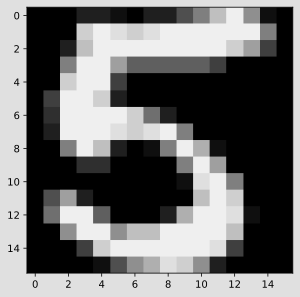

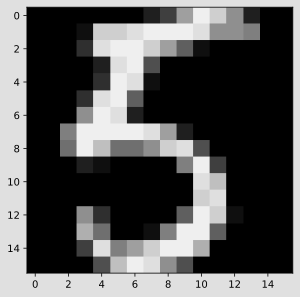

In [3]:
datatrain=read_file("datasets/usps_train.txt")
datatest=read_file("datasets/usps_train.txt")

display_image(datatrain[5][4])
display_image(datatest[5][8])

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 2</h1>

La fonction <code>learn_MAP_parameters</code> prend en argument un paramètre <code>images_classe</code> qui contient la liste de toutes les images d'une classe de la base d'apprentissage (par exemple, toutes les images correspondant au chiffre 3). On rappelle qu'une image est une liste de <code>NB_PIXELS</code> niveaux de gris (nombres entiers compris entre 0 et <code>NB_NIVEAUX_GRIS-1</code>=15). Pour chaque pixel i, $0 \leq i <$ <code>NB_PIXELS</code>, la fonction estime par <b>maximum a posteriori</b> les paramètres de la distribution 

$$P(X_i | C = classe) \text{, où:}$$

* $X_i$ est la variable aléatoire représentant la valeur du ième pixel. Le domaine de cette variable aléatoire est donc l'ensemble ${0, 1, \ldots, 15}$ car il y a <code>NB_NIVEAUX_GRIS</code>=16 niveaux de gris;
* $C$ est la variable classe du problème de classification et classe est le chiffre représenté sur toutes les images.

La distribution $P(X_i | C = classe)$ est donc la distribution des niveaux de gris du ième pixel sur l'ensemble des images du chiffre <code>classe</code> de la base d'apprentissage.

Le paramètre <code>smoothing</code> est l'<i>a priori</i> que l'on rajoute aux tables de comptage (une valeur de 0.1 est suffisant). Rajouter un tel nombre permet d'avoir des distributions strictement positives, ce qui peut être utile dans le cas où certains niveaux de gris d'un pixel ne sont jamais observés dans la base d'apprentissage alors qu'ils le sont dans la base de tests. Si on passe la valeur 0 au paramètre <code>smoothing</code>, on apprend les paramètres par <i>maximum de vraisemblance</i>.

Chaque distribution $P(X_i | C = classe)$ est stockée sous la forme d'une <b>liste</b> de <code>NB_NIVEAUX_GRIS</code> nombres réels (compris entre 0 et 1 puisque c'est une probabilité). Enfin, toutes ces listes sont stockées dans un <b>tableau numpy</b> T de taille <code>NB_PIXELS</code>, que la fonction renvoie. Ainsi, chaque élément T[i] doit contenir la distribution <i>a posteriori</i> $P(X_i | C = classe)$.

Ecrivez le code de la fonction <code>learn_MAP_parameters</code>. <b>Attention :</b>Dans votre code, utilisez bien les constantes <code>NB_PIXELS</code> et <code>NB_NIVEAUX_GRIS</code> plutôt que leurs valeurs. Ce sera important pour la suite.

In [4]:
import numpy as np


def learn_MAP_parameters(images_classe, smoothing) :
    liste = list()
    for i in range(NB_PIXELS) :
        a = [smoothing] * NB_NIVEAUX_GRIS
        liste.append(a)
    for image in images_classe :
        for i, pixel in enumerate(image):
            liste[i][pixel] += 1
    for element in liste :
        for i in range (NB_NIVEAUX_GRIS) :
            element[i] /= (len(images_classe)+(smoothing * NB_NIVEAUX_GRIS))
            
    return liste


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 3</h1>

Testez bien que le tableau T retourné par votre fonction (lorsqu'on l'applique sur les données d'apprentissage de la classe 0, avec un smoothing de 0,1) contient <code>NB_PIXELS</code> éléments et que le premier élément est une liste de <code>NB_NIVEAUX_GRIS</code>=16 valeurs.

Vérifiez également que T[6] correspond à peu près à la liste ci-dessous:

```
[0.2535128805620609,
 0.05779524924723987,
 0.040230846436935426,
 0.03437604550016728,
 0.040230846436935426,
 0.04357644697223151,
 0.04357644697223151,
 0.0469220475075276,
 0.04106724657075945,
 0.05612244897959182,
 0.04357644697223151,
 0.040230846436935426,
 0.05026764804282368,
 0.051940448310471725,
 0.04859484777517564,
 0.10797925727668115]
```

In [5]:
T= learn_MAP_parameters(datatrain[0],0.1)
print(T[6])

[0.25351288056206095, 0.05779524924723988, 0.04023084643693543, 0.034376045500167283, 0.04023084643693543, 0.04357644697223152, 0.04357644697223152, 0.046922047507527605, 0.041067246570759455, 0.05612244897959184, 0.04357644697223152, 0.04023084643693543, 0.050267648042823694, 0.05194044831047173, 0.04859484777517565, 0.10797925727668117]


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 4</h1>

La fonction suivante prend en paramètres le <code>dataset</code> d'apprentissage chargé dans la question 1, ainsi qu'un nombre réel <code>smoothing</code> qui servira lors d'appels à la fonction précédente. Elle renvoie un tableau numpy T contenant, pour chaque pixel i, les paramètres de la probabilité conditionnelle $P(X_i | C)$, autrement dit la distribution conditionnelle de la variable "ième pixel" sachant la variable "classe". 

La variable $X_i$ a 16 valeurs possibles (les 16 niveaux de gris) et la variable $C$ a 10 valeurs possibles (les chiffres de 0 à 9). La distribution conditionnelle $P(X_i | C)$ est donc un tableau 2D de (16 lignes, 10 colonnes) ou (10 lignes, 16 colonnes) suivant que l'on considère $X_i$ sur les lignes ou les colonnes. Pour la suite, il est important que ce $X_i$ soit sur les colonnes (autrement dit, si on utilise un tableau numpy 2D, $X_i$ correspond au 2ème index). Pour simplifier la suite, on représentera ce tableau sous la forme d'une liste L de 10 listes de 16 nombres (ce qui revient à un tableau numpy de taille (10,16)). Autrement dit L[j][k] correspond à $P(X_i = k | C = j)$.

Donc, pour résumer, T est un tableau numpy de listes de listes de réels. T[i] encode la distribution de probabilité conditionnelle $P(X_i | C)$ et T[i][j][k] est la probabilité (nombre réel) $P(X_i = k | C = j)$.

Ecrivez le code de la fonction <code>learn_MAP_conditional_parameters</code>

In [6]:
import numpy
NB_CLASSE = 10
def learn_MAP_conditional_parameters(datatrain, smoothing) :
    liste_classe = []*NB_CLASSE
    for i in range(NB_CLASSE):
        liste_classe.append(learn_MAP_parameters(datatrain[i],smoothing))
    return numpy.array(liste_classe)

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 5</h1>

Appelons T le tableau retourné par la fonction <code>learn_MAP_conditional_parameters</code> si on l'appelle en lui passant la base d'apprentissage lue à la question 1 et un smoothing de 0,1. Alors T[6][3], autrement dit la distribution $P(X_6 | C=3)$ devrait avoir la valeur :

```
[0.1335657974530018,
 0.041085506367495445,
 0.025924802910855062,
 0.02440873256519102,
 0.042601576713159485,
 0.030473013947847176,
 0.0471497877501516,
 0.02289266221952698,
 0.03350515463917525,
 0.06989084293511218,
 0.07292298362644026,
 0.08959975742874468,
 0.0668587022437841,
 0.05169799878714371,
 0.0471497877501516,
 0.20027289266221948]
```

Vérifiez que T et T[0] ont bien, respectivement, 256 et 10 éléments. Vérifiez ensuite que vous obtenez bien la valeur ci-dessus pour T[6][3]. Enfin, vérifiez que $\sum_j P(X_6=j | C=3) \approx 1$.

In [7]:
T = learn_MAP_conditional_parameters(datatrain,0.1)

print(T[3][6])

[0.1335658  0.04108551 0.0259248  0.02440873 0.04260158 0.03047301
 0.04714979 0.02289266 0.03350515 0.06989084 0.07292298 0.08959976
 0.0668587  0.051698   0.04714979 0.20027289]


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 6</h1>

Un réseau de Bayes naïf est un réseau bayésien dans lequel la variable classe C n'a aucun parent et les variables explicatives (features) $X_i$ n'ont qu'un seul parent, la classe C, et pas d'enfant. La figure ci-dessous montre un réseau de Bayes naïf. Il encode le fait que les features $X_i$ sont indépendantes lorsque l'on connaît la valeur de la classe mais qu'elles sont dépendantes si on ne connaît pas cette valeur.

<img src="images/naive_bayes.png" title="naive Bayes">

La fonction <code>create_naive_bayes</code> a pour but de créer en pyAgrum un réseau de Bayes naïf pour le problème de reconnaissance de chiffres et de le renvoyer. Pour cela, le plus simple est d'utiliser les "fast prototypes" de pyAgrum pour créer la structure. Notez que, dans le prototype, "C[0,9]" permet de spécifier la création d'une variable C dont les valeurs vont de 0 à 9. Une fois la structure créée, remplissez les tables de probabilités conditionnelles $P(X_i | C)$ avec les distributions que vous avez calculées dans la question 4. Enfin, pour que le réseau bayésien soit complet, il faut affecter à la variable C une distribution $P(C)$. Celle-ci représente la probabilité qu'en tirant une image au hasard, on tombe sur un chiffre donné. Si l'on n'a aucune raison de penser que des chiffres apparaissent plus que d'autres dans les codes postaux, on peut considérer que $P(C)$ est une distribution uniforme. C'est ce que l'on supposera ici.

Ecrivez le code de la fonction <code>create_naive_bayes</code>. Le paramètre <code>dataset</code> est la base d'apprentissage que vous avez chargée dans la question 1. Le paramètre <code>smoothing</code> est celui que vous utiliserez pour estimer par MAP les distribution conditionnelles $P(X_i | C)$.

In [8]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

def create_naive_bayes (dataset, smoothing) :
    bn_graph = " C[0,9];"
    for i in range (NB_PIXELS) :
        bn_graph+="X{}[0,15];".format(i)
        bn_graph+="C->X{};".format(i)
    bn_tuto = gum.fastBN(bn_graph)
    for i in range (NB_PIXELS) :
        cpt = bn_tuto.cpt("X{}".format(i))
        T = learn_MAP_conditional_parameters(datatrain,0.1)
        cpt[:] = T[:,i]
        cpt.normalizeAsCPT()
    cptC = bn_tuto.cpt("C")
    cptC[:] = [1] * NB_CLASSE
    cptC.normalizeAsCPT()
    return bn_tuto
    


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 7</h1>

Créez un réseau de Bayes naïf <code>bn</code> en exploitant la fonction que vous avez programmée dans la question précédente et en lui passant en arguments le dataset d'apprentissage lu à la question 1 ainsi qu'un smoothing de 0,1. Affichez le réseau. Comme il est assez "gros", nous vous suggérons d'utiliser la commande :

<code>gnb.showBN(bn, size=150)</code>

In [9]:
bn = create_naive_bayes(datatrain, 0.1)

gnb.showBN(bn, size=150)

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 8</h1>

Ecrivez une fonction <code>posterior</code> qui, étant donné un algorithme <code>inf</code> d'inférence de réseaux bayésiens (par exemple une instance de LazyPropagation ou de VariableElimination) et une image encodée sous la forme d'une liste de <code>NB_PIXELS</code> niveaux de gris, renvoie un Potentiel de pyAgrum représentant la distribution de probabilité :

$$P(C | X_1=x_1, X_2=x_2,\ldots, X_n = x_n) \text{, où:}$$

* les $x_i$ sont les observations des variables $X_i$ dans l'image;
* n = <code>NB_PIXELS</code>

Autrement dit, la fonction renvoie la distribution <i>a posteriori</i> de la variable classe sachant l'image.

A l'intérieur de votre fonction, pour saisir les <i>evidence</i> $X_i = x_i$, utilisez la méthode <code>addEvidence</code> de <code>inf</code>. Pour tester votre fonction, créez une instance de LazyPropagation et appelez <code>posterior(inf, dataset[4][5])</code>, où <code>dataset</code> est le dataset d'apprentissage chargé dans la question 1. Le résultat devrait être le suivant :

<img src="images/potential.png" title="P(C | dataset[4][5])">

Notez que le naïve Bayes se trompe : il pense que l'image correspond plutôt à un 9 et, avec une très faible probabilité, à un 4. Or, ici, il s'agit bien d'une image d'un 4 puisque l'image appartient à dataset[4].

In [10]:
def posterior(inf, image) :
    inf.eraseAllEvidence()
    for i in range(NB_PIXELS) :
        inf.addEvidence("X{}".format(i), image[i])
    return inf.posterior("C")

inf = gum.LazyPropagation(bn)
infPosterior = posterior(inf, datatrain[4][5])
gnb.showPotential(infPosterior)

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 9</h1>

Ecrivez une fonction <code>classe_max_1_image</code> qui, étant donné un algorithme <code>inf</code> d'inférence de réseaux bayésiens et une image encodée sous la forme d'une liste de <code>NB_PIXELS</code> niveaux de gris, renvoie un couple contenant la classe la plus probable à laquelle appartient cette image ainsi que la probabilité que l'image appartienne effectivement à cette classe. Pour cela, n'hésitez pas à utiliser la méthode <code>argmax</code> des Potentiels de pyAgrum.

Testez votre fonction avec les mêmes paramètres que la fonction précédente. Attention : vous avez déjà affecté des observations via <code>addEvidence</code> dans la question précédente. Il faut donc les supprimer via 
<code>inf.eraseAllEvidence()</code> avant d'exécuter votre fonction. Comme l'indique l'image ci-dessus, vous devriez obtenir un résultat similaire à :
```
(9, 0.9842446111455871)
```

In [11]:
def classe_max_1_image(inf, image) :
    resultat = posterior(inf, image)
    max = resultat.argmax()
    return (max[0][0]['C'],max[1])

inf = gum.LazyPropagation(bn)
inf.eraseAllEvidence()
print(classe_max_1_image(inf, datatrain[4][5]))


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
(9, 0.9842446111455864)


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 10</h1>

Dans la suite, on va essayer de classifier toutes les images de la base de tests. Il y en a environ 2000. Pour accélérer un peu les calculs, copiez-collez la fonction <code>posterior</code> et substituez <code>addEvidence</code> par <code>chgEvidence</code>.

In [12]:
def posterior1(inf, image) :
    inf.eraseAllEvidence()
    for i in range(NB_PIXELS) :
        inf.chgEvidence("X{}".format(i), image[i])
    return inf.posterior("C")

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 11</h1>

La fonction <code>classe_max_toutes_images</code> prend en arguments le réseau bayésien naïf <code>bn</code> que vous avez créé à la question 7, et le dataset de <b>tests</b> que vous avez chargé à la question 1.

La fonction commence par créer un algorithme d'inférence LazyPropagation et, pour chaque variable pixel $X_i$, $0 \leq i <$ <code>NB_PIXELS</code>, elle ajoute une évidence $X_i = 0$ via la méthode <code>addEvidence</code> (une fois les <i>evidence</i> créées, la fonction <code>posterior</code> se contentera de modifier leur valeur via la méthode <code>chgEvidence</code>. C'est plus rapide que de recréer les <i>evidence</i> pour chaque image).

Ensuite, la fonction crée un tableau numpy 2D, appelons-le <code>matrix</code>, de taille 10x10. Elle le remplit de telle sorte que <code>matrix[i,j]</code> corresponde à la probabilité que le prédicteur <code>classe_max_1_image</code> indique que l'image correspond au chiffre <code>j</code> alors que la vraie classe de l'image est <code>i</code>.

Enfin, la fonction renvoie <code>matrix</code>.

Ecrivez la fonction et exécutez-la en stockant son résultat dans une variable <code>prediction_matrix</code>. Enfin, affichez la valeur de <code>prediction_matrix</code>. Comme il y a 2000 images environ, l'exécution risque de nécessiter plusieurs minutes.

In [13]:
# Fonction pas terminée 
def classe_max_toutes_images(bn,dataset):
    inf = gum.LazyPropagation(bn)
    for i in range(NB_PIXELS):
        variable = str('X{0}').format(i)
        inf.addEvidence(variable, 0)
    matrix = np.zeros((NB_CLASSE, NB_CLASSE ))
    for label in range(NB_CLASSE):
        for image in dataset[label]:
            prediction = classe_max_1_image(inf,image)[0]
            matrix[label][prediction] += 1
        for predictionIndex in range(NB_CLASSE):
            matrix[label][predictionIndex] /= len(dataset[label])
    return matrix

prediction_matrix=classe_max_toutes_images(bn,datatrain)

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 12</h1>

Appliquez la fonction ci-dessous, qui dessine en 3D la matrice <code>prediction_matrix</code>. Cela devrait vous donner le graphique suivant :

<img src="images/matrix.png" title="matrice de prédiction">

Comme on peut le constater, les pics des distributions $P(\text{classe prédite} | \text{vraie classe})$ se trouvent sur la diagonale, ce qui signifie que notre prédicteur par réseau de Bayes naïf fonctionne bien puisque, dans une majorité des cas, il prédit la bonne classe.

<IPython.core.display.Javascript object>


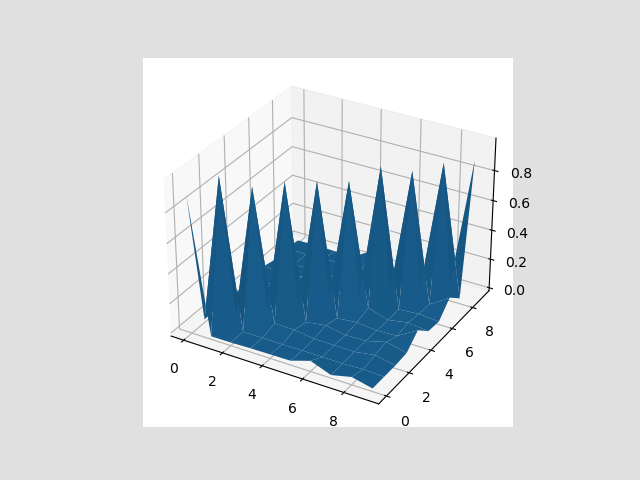

In [14]:
%matplotlib notebook

def dessine_matrice(matrice):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.linspace(0, 9, 10)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, matrice, rstride = 1, cstride=1 )


dessine_matrice(prediction_matrix)


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 13</h1>

L'exactitude est le taux de bonnes classifications, c'est-à-dire le ratio du nombre de chiffres correctement prédits sur le nombre total de chiffres prédits. Ecrivez une fonction <code>accuracy</code> qui, étant donné une matrice de prédiction et un dataset, renvoie ce taux. Appliquez la sur votre matrice de prédiction.

In [15]:
def accuracy (prediction_matrix, dataset) :
    accuracy_number = 0
    for i in range(len(prediction_matrix)) :
        accuracy_number += prediction_matrix[i, i]
    accuracy_number /= len(prediction_matrix)
    return accuracy_number

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Sensibilité à la discrétisation des couleurs</h1>

En début de TP (section Préparation/visualisation), on avait discrétisé les couleurs des images en 16 nuances de gris (<code>NB_NIVEAUX_GRIS = 16</code>). On souhaite maintenant estimer si ce choix affecte l'exactitude. Pour cela, on fait varier cette discrétisation de 2 à 16 valeurs et on réapprend le modèle.

In [16]:
def calcule_accuracy_par_niveau(niveaux_gris):
    """
    Renvoie un dictionnaire {niveau_gris : accuracy}
    """
    global NB_NIVEAUX_GRIS
    
    result = {}
    for nb_niveaux_gris in niveaux_gris:
        print("processing NB_NIVEAUX_GRIS =", nb_niveaux_gris)
        NB_NIVEAUX_GRIS = nb_niveaux_gris

        # relecture et discrétisation des données
        training_data = read_file("datasets/usps_train.txt")
        test_data = read_file("datasets/usps_test.txt")

        # création du naïve Bayes
        bn = create_naive_bayes(training_data, 0.1)

        # calcul de la matrice de prédiction
        prediction_matrix = classe_max_toutes_images(bn, test_data)

        # calcul de l'exactitude
        result[nb_niveaux_gris] = accuracy(prediction_matrix, test_data)
    
    return result


# sensibilite = dictionnaire associant à chaque niveau de gris parmi les
# niveaux de la liste "niveaux_gris" l'exactitude correspondante.
niveaux_gris = [2,3,5,8,12,16]
sensibilite = calcule_accuracy_par_niveau(niveaux_gris)
sensibilite

processing NB_NIVEAUX_GRIS = 2


IndexError: list index out of range

In [ ]:
# on affiche graphiquement l'évolution de l'exactitude en fonction de la
# discrétisation en niveaux de gris
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(niveaux_gris, [sensibilite[niveau] for niveau in sensibilite])
plt.ylim([0,1])
plt.show()